In [1]:
from dataset import myDataset_labelHM
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS')
else :
    device = torch.device('cpu')
    print('Using CPU')

Using MPS


In [3]:
#Parameters
path_csv = 'data/h&mdataset/articles.csv'
path_images = 'data/h&mdataset/images/'
dataset = myDataset_labelHM(path_images, path_csv)
batch_size = 64
ratio_frozen_layers =  0.0
num_epochs = 1
learning_rate = 0.00001
num_classes = dataset.get_num_classes()
num_samples = len(dataset)
num_samples

105099

In [4]:
#Split train/validation/test 
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [5]:
#Finetuning of a pretrained model resnet50


class ResNet50(nn.Module):
    def __init__(self, num_classes, ratio_frozen_layers=0.0):
        super(ResNet50, self).__init__()
        self.ration_frozen_layers = ratio_frozen_layers
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.resnet.train()
        self.fc = nn.Linear(2048, num_classes)
        #get the layers of the resnet model
        self.resnet_layers = list(self.resnet.children())
        self.numbers_of_layers = len(self.resnet_layers)
        self.numbers_of_frozen_layers = int(self.numbers_of_layers*self.ration_frozen_layers)
        #freeze the layers of the resnet model to a certain layer defined by "number of frozen layers"
        for i in range(0, self.numbers_of_frozen_layers):
            for param in self.resnet_layers[i].parameters():
                param.requires_grad = False
        
    
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def show_number_frozen_layers(self):
        print(f'{self.numbers_of_frozen_layers} frozen layers out of {self.numbers_of_layers} layers')

model = ResNet50(num_classes, ratio_frozen_layers)
model.to(device)
model.show_number_frozen_layers()

#Loss and optimizer
criterion = nn.CrossEntropyLoss()

#Fine tune all layers of the model
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Using cache found in /Users/jskaf/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 frozen layers out of 9 layers


In [6]:
def train(model, train_loader, criterion, optimizer, epoch):
    print('Training epoch {}'.format(epoch+1))
    model.train()
    training_loss = 0.0
    index_batch = 0
    for batch in train_loader:
        images, labels ,_ ,_ = batch
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        
        #Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        index_batch += 1
        if index_batch%10 == 0:
            print('Batch {} out of {}'.format(index_batch, len(train_loader)))
    return training_loss/len(train_loader)

In [7]:
def evaluate(model, val_loader, epoch, criterion):
    global num_classes
    print('Evaluating epoch {}'.format(epoch+1))
    model.eval()
    validation_loss = 0.0
    #Validation and print of accuracy per class
    with torch.no_grad():
        class_correct = list(0. for i in range(num_classes))
        class_total = list(0. for i in range(num_classes))
        index_batch = 0
        for batch in val_loader:
            images, labels, _ , _= batch
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            index_batch += 1
            if index_batch%10 == 0:
                print('Batch {} out of {}'.format(index_batch, len(val_loader)))

        for i in range(num_classes):
            if class_total[i] == 0:
                print('No validation data for class {}'.format(i+1))
            else:
                print('Accuracy of class %5s : %2d %%' % (i+1, 100 * class_correct[i] / class_total[i]))
    return validation_loss/len(val_loader)
    

In [8]:
#Train the model
train_losses = []
validation_losses = []
for epoch in tqdm(range(num_epochs)):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    validation_loss = evaluate(model, val_loader, epoch, criterion)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

  0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 1


/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clo

Batch 10 out of 1314
Batch 20 out of 1314
Batch 30 out of 1314
Batch 40 out of 1314
Batch 50 out of 1314
Batch 60 out of 1314
Batch 70 out of 1314
Batch 80 out of 1314
Batch 90 out of 1314
Batch 100 out of 1314
Batch 110 out of 1314
Batch 120 out of 1314
Batch 130 out of 1314
Batch 140 out of 1314
Batch 150 out of 1314
Batch 160 out of 1314
Batch 170 out of 1314
Batch 180 out of 1314
Batch 190 out of 1314
Batch 200 out of 1314
Batch 210 out of 1314
Batch 220 out of 1314
Batch 230 out of 1314
Batch 240 out of 1314
Batch 250 out of 1314
Batch 260 out of 1314
Batch 270 out of 1314
Batch 280 out of 1314
Batch 290 out of 1314
Batch 300 out of 1314
Batch 310 out of 1314
Batch 320 out of 1314
Batch 330 out of 1314
Batch 340 out of 1314
Batch 350 out of 1314
Batch 360 out of 1314
Batch 370 out of 1314
Batch 380 out of 1314
Batch 390 out of 1314
Batch 400 out of 1314
Batch 410 out of 1314
Batch 420 out of 1314
Batch 430 out of 1314
Batch 440 out of 1314
Batch 450 out of 1314
Batch 460 out of 13

/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clo

Batch 10 out of 165
Batch 20 out of 165
Batch 30 out of 165
Batch 40 out of 165
Batch 50 out of 165
Batch 60 out of 165
Batch 70 out of 165
Batch 80 out of 165
Batch 90 out of 165
Batch 100 out of 165
Batch 110 out of 165
Batch 120 out of 165
Batch 130 out of 165
Batch 140 out of 165
Batch 150 out of 165
Batch 160 out of 165


100%|██████████| 1/1 [21:07<00:00, 1267.96s/it]

Accuracy of class     1 :  0 %
Accuracy of class     2 :  0 %
Accuracy of class     3 :  0 %
Accuracy of class     4 :  0 %
Accuracy of class     5 :  0 %
Accuracy of class     6 :  0 %
Accuracy of class     7 :  0 %
Accuracy of class     8 :  0 %
Accuracy of class     9 :  0 %
Accuracy of class    10 :  0 %
Accuracy of class    11 :  0 %
Accuracy of class    12 :  0 %
Accuracy of class    13 :  0 %
Accuracy of class    14 :  0 %
Accuracy of class    15 :  0 %
Accuracy of class    16 :  0 %
Accuracy of class    17 :  0 %
Accuracy of class    18 :  0 %
Accuracy of class    19 :  0 %
Accuracy of class    20 :  0 %
Accuracy of class    21 :  0 %
Accuracy of class    22 :  0 %
Accuracy of class    23 :  0 %
Accuracy of class    24 :  0 %
Accuracy of class    25 :  0 %
Accuracy of class    26 :  0 %
Accuracy of class    27 :  0 %
Accuracy of class    28 :  0 %
Accuracy of class    29 :  0 %
Accuracy of class    30 :  0 %
Accuracy of class    31 :  0 %
Accuracy of class    32 :  0 %
Accuracy

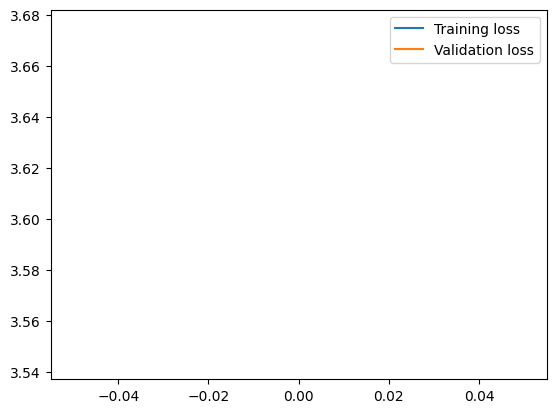

In [9]:
#Plot the losses and save them
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend()
plt.savefig('losses.png')
plt.show()

In [10]:
#Test the model for each class
def test(model, test_loader):
    global num_classes
    model.eval()
    with torch.no_grad():
        index_batch = 0
        class_correct = list(0. for i in range(num_classes))
        class_total = list(0. for i in range(num_classes))
        for batch in test_loader:
            images, labels, _ , _ = batch
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            index_batch += 1
            if index_batch%10 == 0:
                print('Batch {} out of {}'.format(index_batch, len(test_loader)))

        for i in range(num_classes):
            if class_total[i] == 0:
                print('No test data for class {}'.format(i))
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))
            
test(model, test_loader)

/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clo

Batch 10 out of 165
Batch 20 out of 165
Batch 30 out of 165
Batch 40 out of 165
Batch 50 out of 165
Batch 60 out of 165
Batch 70 out of 165
Batch 80 out of 165
Batch 90 out of 165
Batch 100 out of 165
Batch 110 out of 165
Batch 120 out of 165
Batch 130 out of 165
Batch 140 out of 165
Batch 150 out of 165
Batch 160 out of 165
Accuracy of     0 :  0 %
Accuracy of     1 :  0 %
Accuracy of     2 :  0 %
Accuracy of     3 :  0 %
Accuracy of     4 :  0 %
Accuracy of     5 :  0 %
Accuracy of     6 :  0 %
Accuracy of     7 :  0 %
Accuracy of     8 :  0 %
Accuracy of     9 :  0 %
Accuracy of    10 :  0 %
Accuracy of    11 :  0 %
Accuracy of    12 :  0 %
Accuracy of    13 :  0 %
Accuracy of    14 :  0 %
Accuracy of    15 :  0 %
Accuracy of    16 :  0 %
Accuracy of    17 :  0 %
Accuracy of    18 :  0 %
Accuracy of    19 :  0 %
Accuracy of    20 :  0 %
Accuracy of    21 :  0 %
Accuracy of    22 :  0 %
Accuracy of    23 :  0 %
Accuracy of    24 :  0 %
Accuracy of    25 :  0 %
Accuracy of    26 :  0 

In [11]:
#Save the model
torch.save(model.state_dict(), 'resnet_finetuned.pth')